In [6]:
# Importing necessary libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import (BaggingRegressor, AdaBoostRegressor, RandomForestRegressor,  
                              GradientBoostingRegressor, StackingRegressor)
from sklearn.model_selection import (StratifiedKFold, cross_validate, train_test_split,
                                     KFold, cross_val_score, GridSearchCV)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from xgboost import XGBRegressor
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set display options
plt.rcParams['figure.dpi'] = 100

In [7]:
cleaned_df = pd.read_csv('cleaned_data_for_ML.csv')
cleaned_df.head()

,bathrooms,bedrooms,livingArea,price,lotArea_sqft,log_price,log_lotArea_sqft,log_livingArea,homeType_0,homeType_1,...,state_8,state_9,state_10,state_11,state_12,state_13,state_14,state_15,state_16,state_17
0,1.098612,1.386294,7.515345,12.898972,8.832442,12.898972,8.832442,7.515345,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.098612,1.386294,7.358831,12.449023,11.077527,12.449023,11.077527,7.358831,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.098612,1.386294,7.723562,13.383190,11.519152,13.383190,11.519152,7.723562,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.098612,1.386294,7.430707,12.691584,12.856649,12.691584,12.856649,7.430707,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.609438,1.609438,8.063378,13.996999,10.682917,13.996999,10.682917,8.063378,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X = cleaned_df[['bathrooms', 'bedrooms','log_lotArea_sqft', 'log_livingArea', 'homeType_0',
       'homeType_1', 'homeType_2', 'homeType_3', 'homeType_4', 'homeType_5',
       'homeType_6', 'homeType_7', 'homeType_8', 'homeType_9', 'homeType_10',
       'homeType_11', 'state_0', 'state_1', 'state_2', 'state_3', 'state_4',
       'state_5', 'state_6', 'state_7', 'state_8', 'state_9', 'state_10',
       'state_11', 'state_12', 'state_13', 'state_14', 'state_15', 'state_16',
       'state_17']]


y = cleaned_df['log_price']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
p = X.shape[1]
train_n = X_train.shape[0]
test_n = X_test.shape[0]

In [10]:
models = {
    "Elastic Net": make_pipeline(
        RobustScaler(), 
        ElasticNet(alpha=0.0006, l1_ratio=0.95)  # Elastic Net model with regularization
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=350  # Random Forest model with 350 trees
    ),
    "XGBoost": XGBRegressor(  # Default XGBoost model configuration
    ),                                      
    "Gradient Boosting": make_pipeline(
        StandardScaler(),
        GradientBoostingRegressor(
            n_estimators=3500,  # Gradient Boosting model with extensive tuning
            learning_rate=0.005,     
            max_depth=4, 
            max_features='sqrt',
            min_samples_leaf=16, 
            min_samples_split=11, 
            loss='huber', 
            random_state=6
        )
    )
}


In [11]:
# Dictionary to hold model evaluation metrics for both training and testing sets
models_evaluation = {
    'R^2': {'Training': {}, 'Testing': {}},
    'Adjusted R^2': {'Training': {}, 'Testing': {}},
    'MAE': {'Training': {}, 'Testing': {}},
    'MSE': {'Training': {}, 'Testing': {}},
    'RMSE': {'Training': {}, 'Testing': {}}
}


In [38]:


# Suppress warnings for cleaner output
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Loop through each model in the base_models dictionary
    for name, model in models.items():
        # Fit the model
        fitted_model = model.fit(X_train, y_train)
        # Predictions on training and testing sets
        y_pred_train = fitted_model.predict(X_train)
        y_pred_test = fitted_model.predict(X_test)

        # Calculate R-Squared for training and testing sets
        r2_train = fitted_model.score(X_train, y_train)
        r2_test = fitted_model.score(X_test, y_test)
        models_evaluation['R^2']['Training'][name] = r2_train
        models_evaluation['R^2']['Testing'][name] = r2_test

        # Calculate Adjusted R-Squared for training and testing sets
        adj_r2_train = 1 - (1 - r2_train) * (train_n - 1) / (train_n - p - 1)
        adj_r2_test = 1 - (1 - r2_test) * (test_n - 1) / (test_n - p - 1)
        models_evaluation['Adjusted R^2']['Training'][name] = adj_r2_train
        models_evaluation['Adjusted R^2']['Testing'][name] = adj_r2_test

        # Calculate Mean Absolute Error (MAE) for training and testing sets
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        models_evaluation['MAE']['Training'][name] = mae_train
        models_evaluation['MAE']['Testing'][name] = mae_test

        # Calculate Mean Squared Error (MSE) for training and testing sets
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        models_evaluation['MSE']['Training'][name] = mse_train
        models_evaluation['MSE']['Testing'][name] = mse_test

        # Calculate Root Mean Square Error (RMSE) for training and testing sets
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)
        models_evaluation['RMSE']['Training'][name] = rmse_train
        models_evaluation['RMSE']['Testing'][name] = rmse_test

        # Output the evaluation metrics for each model
        print(f'\n===== Model: {name} =====')
        print('Metric       Training             Testing')
        print(f'R^2          {r2_train:.4f}            {r2_test:.4f}')
        print(f'Adj R^2      {adj_r2_train:.4f}            {adj_r2_test:.4f}')
        print(f'MAE          {mae_train:.4f}            {mae_test:.4f}')
        print(f'MSE          {mse_train:.4f}            {mse_test:.4f}')
        print(f'RMSE         {rmse_train:.4f}            {rmse_test:.4f}')



===== Model: Elastic Net =====
Metric       Training             Testing
R^2          0.9379            0.8939
Adj R^2      0.9107            1.4885
MAE          0.0684            0.0810
MSE          0.0096            0.0160
RMSE         0.0981            0.1264

===== Model: Random Forest =====
Metric       Training             Testing
R^2          0.9827            0.8538
Adj R^2      0.9751            1.6731
MAE          0.0356            0.0972
MSE          0.0027            0.0220
RMSE         0.0519            0.1483

===== Model: XGBoost =====
Metric       Training             Testing
R^2          0.9995            0.8449
Adj R^2      0.9993            1.7141
MAE          0.0059            0.0981
MSE          0.0001            0.0233
RMSE         0.0086            0.1528

===== Model: Gradient Boosting =====
Metric       Training             Testing
R^2          0.9549            0.8844
Adj R^2      0.9351            1.5321
MAE          0.0511            0.0824
MSE          0.0

In [39]:
# Creating and sorting DataFrames from the models' evaluation metrics for easier plotting and analysis.
# The DataFrames will help visualize and compare the performance of each model.

# DataFrame for R-Squared values, sorted by testing performance in descending order (higher is better)
R_2 = pd.DataFrame(models_evaluation['R^2']).sort_values(by='Testing', ascending=False)

# DataFrame for Adjusted R-Squared values, sorted similarly as it adjusts for the number of predictors in the model
Adjusted_R_2 = pd.DataFrame(models_evaluation['Adjusted R^2']).sort_values(by='Testing', ascending=False)

# DataFrame for Mean Absolute Error (MAE), sorted by testing performance in ascending order (lower is better)
MAE = pd.DataFrame(models_evaluation['MAE']).sort_values(by='Testing', ascending=True)

# DataFrame for Mean Squared Error (MSE), also sorted to show models with lower errors first
MSE = pd.DataFrame(models_evaluation['MSE']).sort_values(by='Testing', ascending=True)

# DataFrame for Root Mean Square Error (RMSE), which is the square root of MSE, sorted in the same manner
RMSE = pd.DataFrame(models_evaluation['RMSE']).sort_values(by='Testing', ascending=True)

# These DataFrames are now ready to be used for plotting or further analysis to compare the effectiveness of different models.


### Visualizing  Results

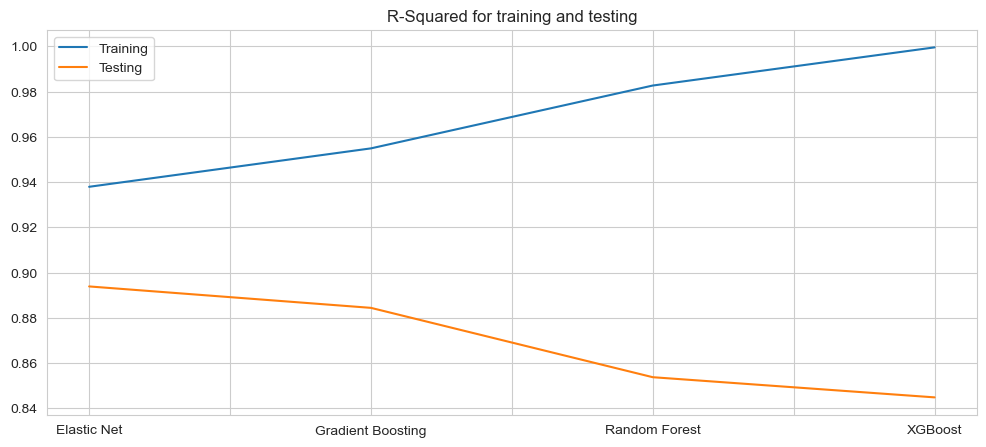

In [40]:
#order the results by testing values

(
    R_2.
    plot(kind='line', figsize=(12, 5)).
    set_title('R-Squared for training and testing')
);

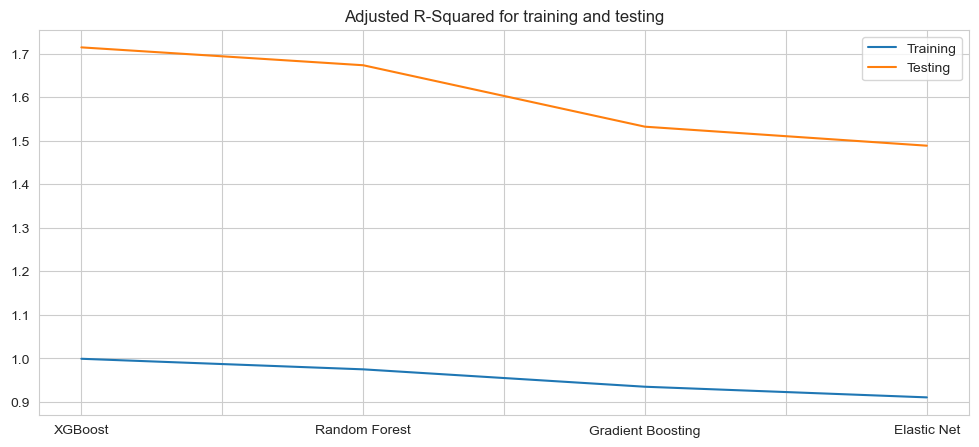

In [41]:
#order the results by testing values

(
    Adjusted_R_2.
    plot(kind='line', figsize=(12, 5)).
    set_title('Adjusted R-Squared for training and testing')
);

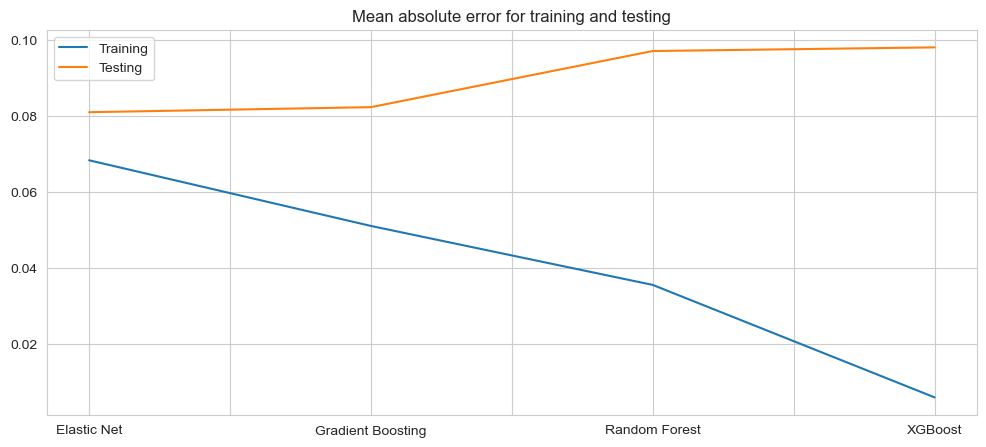

In [42]:
#order the results by testing values

(
    MAE.
    plot(kind='line', figsize=(12, 5)).
    set_title('Mean absolute error for training and testing')
);

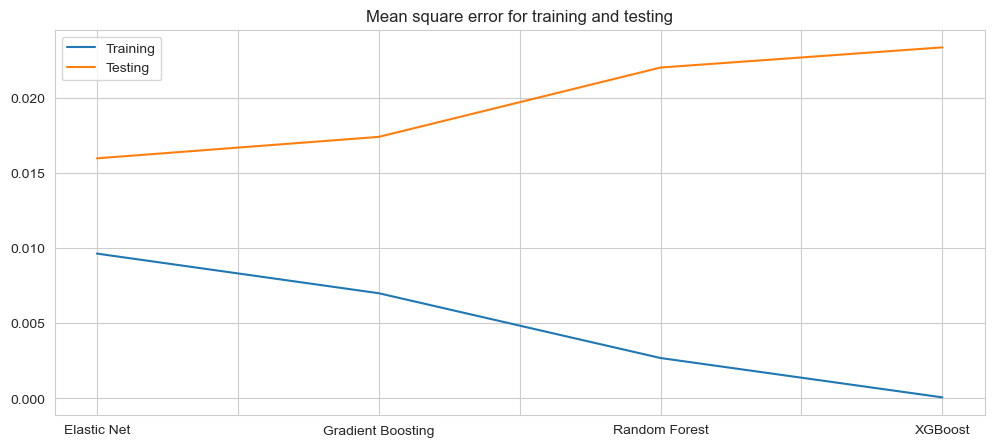

In [43]:
#order the results by testing values

(
    MSE.
    plot(kind='line', figsize=(12, 5)).
    set_title('Mean square error for training and testing')
);

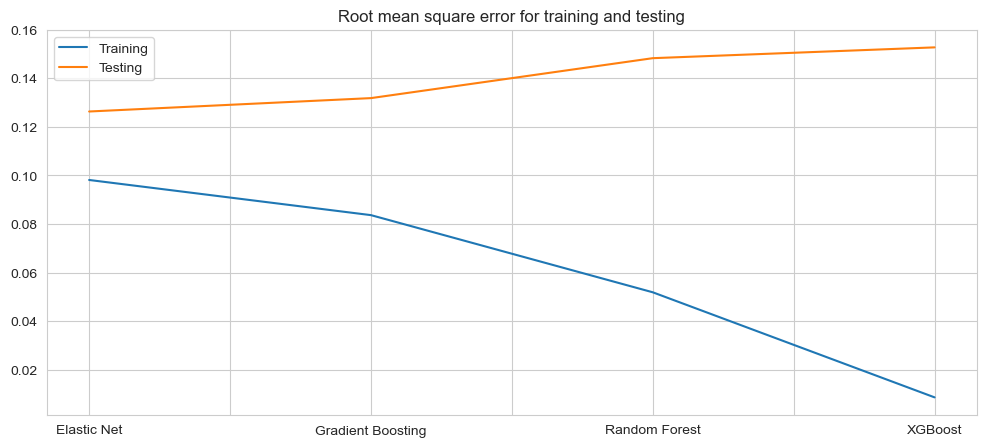

In [44]:
#order the results by testing values

(
    RMSE.
    plot(kind='line', figsize=(12, 5)).
    set_title('Root mean square error for training and testing')
);

<h3> Elastic Net estimator permformed well , compared to others:</h3><ul>
<li><b>Max</b> score with testing data <b>(low variance)</b> and <b>Normal</b> score with training data<b> (low bias)</b>.
<li><b>Lower</b> error with training data and also a <b>justified</b> error with training data.

In [47]:
# Configuration for cross-validation to evaluate model performance with R-Squared and RMSE metrics.

# Dictionaries to store the results of R-Squared and RMSE for each model
r_2_results = {'R-Squared': {}, 'Mean': {}, 'std': {}}
rmse_results = {'RMSE': {}, 'Mean': {}, 'std': {}}

# Set the number of folds for K-Fold cross-validation
n_folds = 5
kfold = KFold(n_folds, shuffle=True, random_state=42)

# Iterating over each model to perform cross-validation
for name, model in models.items():
    # Compute R-Squared scores using cross-validation
    r_2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=kfold)
    
    # Calculate RMSE using cross-validation
    rmse_scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))

    # Save the R-Squared results for each model
    r_2_results['R-Squared'][name] = r_2_scores
    r_2_results['Mean'][name] = r_2_scores.mean()
    r_2_results['std'][name] = r_2_scores.std()
    
    # Save the RMSE results for each model
    rmse_results['RMSE'][name] = rmse_scores
    rmse_results['Mean'][name] = rmse_scores.mean()
    rmse_results['std'][name] = rmse_scores.std()
    
    # Print a completion message for each model
    print(f"{'*' * 10} {name} is Done! {'*' * 10}".center(50))

# Note: Ensure that `X_train` and `y_train` are defined and appropriate for use with your models.


    ********** Elastic Net is Done! **********    
   ********** Random Forest is Done! **********   
      ********** XGBoost is Done! **********      
 ********** Gradient Boosting is Done! ********** 


### Visualizing the results

><b>1) R-Squared

In [48]:
# Constructing a DataFrame to visualize the cross-validation results for R-Squared metrics of each model

# Prepare data for the DataFrame
model_names = list(r_2_results['R-Squared'].keys())
max_r2 = [r_2_results['R-Squared'][model].max() for model in model_names]
mean_r2 = [r_2_results['Mean'][model] for model in model_names]
min_r2 = [r_2_results['R-Squared'][model].min() for model in model_names]
std_r2 = [r_2_results['std'][model] for model in model_names]

# Creating the DataFrame
r_2_cv_results = pd.DataFrame({
    'Max': max_r2,
    'Mean': mean_r2,
    'Min': min_r2,
    'std': std_r2
}, index=model_names)

# DataFrame is now ready to be used for plotting or further analysis


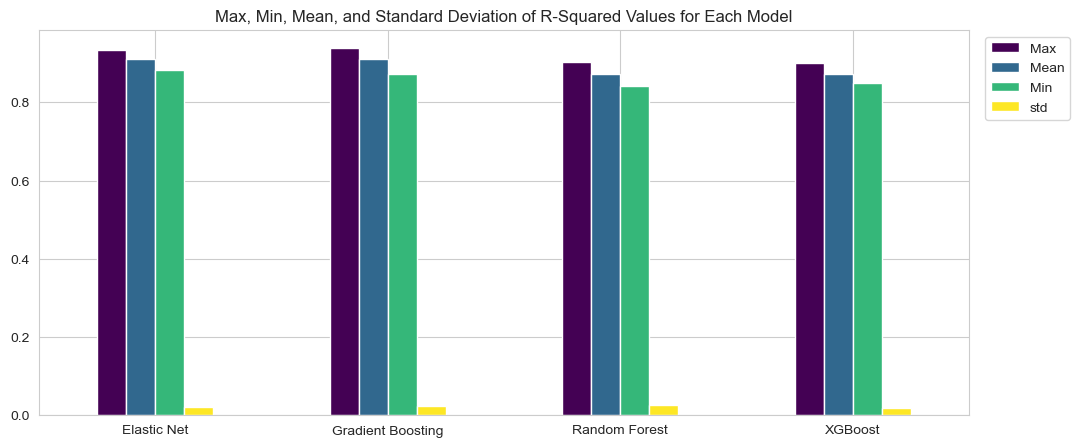

In [60]:
r_2_cv_results = r_2_cv_results.sort_values(by='Mean', ascending=False)

# Creating a bar plot to visualize the Max, Min, Mean, and standard deviation of R-Squared values for each model
ax = r_2_cv_results.plot(kind='bar',
                         title='Max, Min, Mean, and Standard Deviation of R-Squared Values for Each Model',
                         figsize=(12, 5),
                         colormap='viridis')  # Using 'viridis' colormap for a visually appealing color scheme

# Setting the location of the legend to be outside the plot area for better clarity
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Display the plot
plt.show()


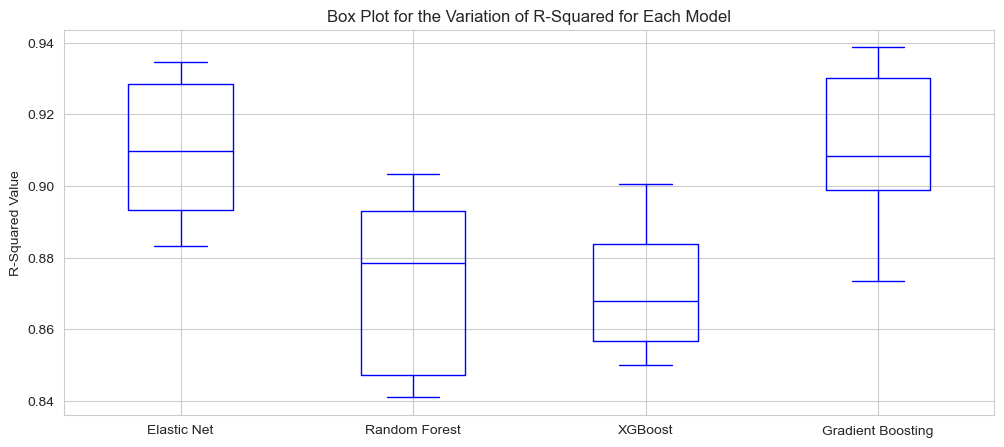

In [50]:
# Constructing a DataFrame from the R-Squared scores for each model
scores = pd.DataFrame(r_2_results['R-Squared'])

# Creating a box plot to display the variation of R-Squared values for each model
ax = scores.plot(kind='box',
                 title='Box Plot for the Variation of R-Squared for Each Model',
                 figsize=(12, 5),
                 color='blue')  # Color can be adjusted as preferred

# Enhancing plot aesthetics
ax.set_ylabel('R-Squared Value')  # Adding y-axis label
ax.grid(True)  # Adding grid for easier reading of values

# Display the plot
plt.show()


><b>2) RMSE

In [51]:
# Constructing a DataFrame to visualize the cross-validation results for RMSE metrics of each model

# Prepare data for the DataFrame
model_names = list(rmse_results['RMSE'].keys())
max_rmse = [rmse_results['RMSE'][model].max() for model in model_names]
mean_rmse = [rmse_results['Mean'][model] for model in model_names]
min_rmse = [rmse_results['RMSE'][model].min() for model in model_names]
std_rmse = [rmse_results['std'][model] for model in model_names]

# Creating the DataFrame
rmse_cv_results = pd.DataFrame({
    'Max': max_rmse,
    'Mean': mean_rmse,
    'Min': min_rmse,
    'std': std_rmse
}, index=model_names)

# The DataFrame is now ready for visualization or further analysis.


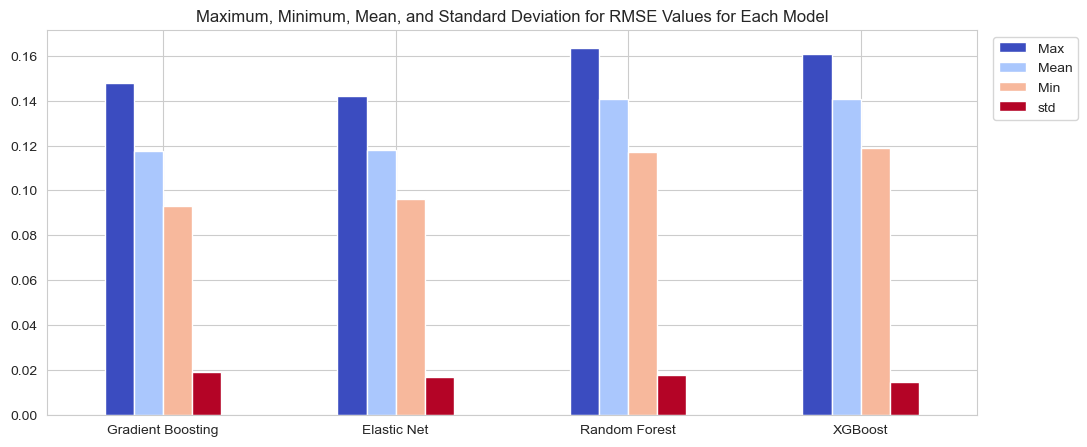

In [61]:
rmse_cv_results = rmse_cv_results.sort_values(by='Mean', ascending=True)

# Creating a bar plot to visualize the Maximum, Minimum, Mean, and Standard Deviation of RMSE values for each model
ax = rmse_cv_results.plot(kind='bar',
                          title='Maximum, Minimum, Mean, and Standard Deviation for RMSE Values for Each Model',
                          figsize=(12, 5),
                          colormap='coolwarm')  # Using 'coolwarm' colormap for a visually appealing contrast

# Setting the location of the legend to be outside the plot area for better clarity
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Display the plot
plt.show()


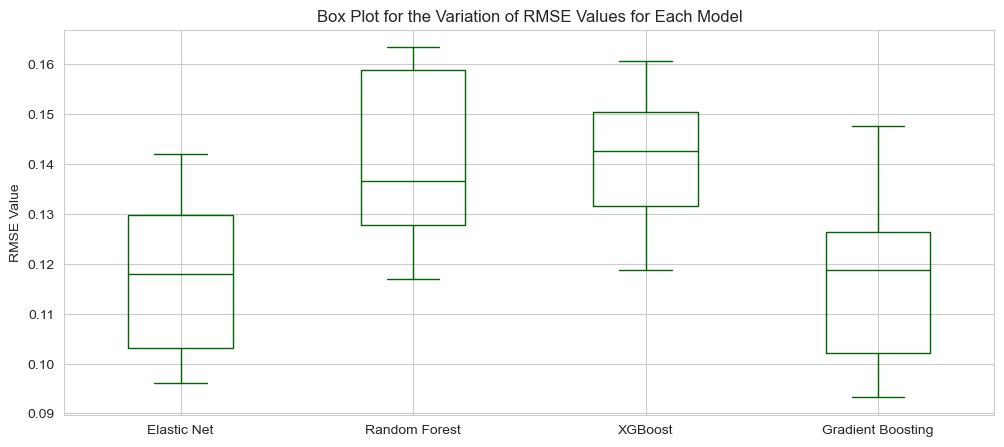

In [53]:
# Creating a DataFrame from the RMSE scores for each model
scores_rmse = pd.DataFrame(rmse_results['RMSE'])

# Generating a box plot to display the variation of RMSE values for each model
ax = scores_rmse.plot(kind='box',
                      title='Box Plot for the Variation of RMSE Values for Each Model',
                      figsize=(12, 5),
                      color='darkgreen')  # Color can be adjusted as preferred

# Enhancing plot aesthetics
ax.set_ylabel('RMSE Value')  # Adding y-axis label
ax.grid(True)  # Adding grid for easier reading of values

# Display the plot
plt.show()


<h4> According to the evaluation of train/test and cross-validation results, ElasticNet emerges as the optimal choice:</h4><br>
<h4>In train/test:</h4>
    <ul>
        <li><b>ElasticNet demonstrates strong performance in the train/test phase, achieving a score of 94.0779% for training and 89.5601% for testing.
        <li><b>It also exhibits low Root Mean Square Error (RMSE) values for both training and testing datasets
    </ul>
<h4>In cross validation :</h4>
    <ul>
        <li><b>During cross-validation, ElasticNet maintains a high mean score of 91.1784%, with a relatively low standard deviation of 1.1132%.
        <li><b>Additionally, the model showcases low mean RMSE values of 11.6398%, accompanied by a standard deviation of 1.1601%.

### ElasticNet model Fine tuning with GridSearchCV

In [62]:
# Define the parameter grid for ElasticNet
parameters_grid = {
    "max_iter": [1, 5, 10, 100],
    "alpha": [0.0005, 0.005, 0.001, 0.01, 0.1, 1, 10, 100],
    "l1_ratio": np.arange(0.0, 1.0, 0.1)
}

# Set up 10-fold cross-validation
kfold = KFold(n_splits=10)

# Initialize the ElasticNet regressor
eNet = ElasticNet(random_state=42)

# Set up GridSearchCV with the defined parameter grid and R^2 as the scoring method
eNet_grid = GridSearchCV(eNet, parameters_grid, scoring='r2', cv=kfold, verbose=1)
eNet_grid.fit(X_train, y_train)

# Get the best model from the grid search
best_model = eNet_grid.best_estimator_

# Calculate R^2 before and after hyperparameter tuning
r2_before = round(cross_val_score(eNet, X_train, y_train, scoring='r2', cv=kfold).mean() * 100, 3)
r2_after = round(eNet_grid.best_score_ * 100, 3)


Fitting 10 folds for each of 320 candidates, totalling 3200 fits


In [56]:

# Output the results
print('Elastic Net Model:')
print(f'Before tuning the hyperparameters: R^2 = {r2_before}%')
print(f'After tuning the hyperparameters: R^2 = {r2_after}%')

Elastic Net Model:
Before tuning the hyperparameters: R^2 = 91.3%
After tuning the hyperparameters: R^2 = 94.5%
